**Importing Libraries**

In [1]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install opencv-contrib-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install scikit-image --user

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
pip install keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import os, time, h5py, random, cv2
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from skimage.transform import resize
from sklearn.feature_extraction import image as skimg

from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv3D
from keras.layers import Lambda, Concatenate, MaxPooling2D, Maximum, Add
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from keras.losses import MeanSquaredError
from keras.callbacks import Callback,LearningRateScheduler
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

%matplotlib inline

**Load NYU2 Dataset Function**

In [9]:
import os
import random
import numpy as np
from sklearn.feature_extraction import image as skimg
from PIL import Image

def load_train_dataset_from_subfolders(base_directory, count=20, patch_count=10):
    """
    Load train dataset from a directory with subfolders containing images.
    
    Args:
        base_directory (str): Path to the base directory containing subfolders with images.
        count (int): Number of images to load from all subfolders combined.
        patch_count (int): Number of patches to extract per image.
    
    Returns:
        dict: A dictionary containing clear image patches, transmission values, 
              and haze image patches.
    """
    trans_vals = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
    nyu_image_patches = None
    nyu_haze_patches = None
    nyu_random_transmission = []

    # Collect all image paths from subfolders
    image_paths = []
    for root, _, files in os.walk(base_directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))
    
    # Limit to `count` number of images
    image_paths = image_paths[:count]

    # Load and process images
    for file in image_paths:
        image = np.array(Image.open(file).convert('RGB')) / 255.0  # Normalize to 0-1
        patches = skimg.extract_patches_2d(image, (16, 16), max_patches=patch_count)

        if nyu_image_patches is not None:
            nyu_image_patches = np.concatenate((nyu_image_patches, patches))
        else:
            nyu_image_patches = patches

    # Create haze patches with transmission values
    for image in nyu_image_patches:
        transmission = random.choice(trans_vals)
        haze_image = image * transmission + (1 - transmission)
        nyu_random_transmission.append(transmission)

        if nyu_haze_patches is not None:
            nyu_haze_patches = np.concatenate((nyu_haze_patches, [haze_image]))
        else:
            nyu_haze_patches = np.array([haze_image])

    return {
        "clear_image_patch": nyu_image_patches,
        "transmission_values": nyu_random_transmission,
        "haze_image_patch": nyu_haze_patches
    }

# Example usage
base_dir = "C:/Users/adity/OneDrive/Desktop/211172/Major Project/nyu_data/data/nyu2_train"
result = load_train_dataset_from_subfolders(base_dir)


In [10]:
# Define a function to create a training dataset, with the option to specify the number of samples and patches per sample.
# Arguments:
# - count: Number of samples to load from the dataset.
# - patch_count: Number of patches to create from each sample.
# - comp: Compression type for storing the dataset (default is 9).
# - shuff: Whether to shuffle the dataset or not (True by default).
def create_train_dataset(count=20, patch_count=10, comp=9, shuff=True):
  
  # Record the start time to measure the time taken to load the dataset.
  start_time = time.time()

  # Load the dataset using the 'load_train_dataset' function, passing the count and patch_count parameters.
  d = load_train_dataset(count, patch_count)

  # Print the time taken to create the dictionary (d contains the loaded dataset).
  print("--- %s seconds in creating dictionary ---" % (time.time() - start_time))
  print("Dictionary created")

  # Record the start time to measure the time taken to create the HDF5 dataset.
  start_time = time.time()

  # Create an HDF5 file ('train_data.hdf5') to store the training data.
  train_dataset = h5py.File("train_data.hdf5", "w")

  # Create the "clear_image" dataset within the HDF5 file, storing the 'clear_image_patch' from the loaded data.
  # Apply compression and shuffling options as specified by the function parameters.
  dset = train_dataset.create_dataset("clear_image", data=d["clear_image_patch"], compression=comp, shuffle=shuff)

  # Create the "transmission_value" dataset within the HDF5 file, storing the 'transmission_values' from the loaded data.
  dset = train_dataset.create_dataset("transmission_value", data=d["transmission_values"], compression=comp, shuffle=shuff)

  # Create the "haze_image" dataset within the HDF5 file, storing the 'haze_image_patch' from the loaded data.
  dset = train_dataset.create_dataset("haze_image", data=d["haze_image_patch"], compression=comp, shuffle=shuff)

  # Close the HDF5 file after writing all datasets.
  train_dataset.close()

  # Print the time taken to create the dataset.
  print("--- %s seconds in creating dataset ---" % (time.time() - start_time))

  # Print the compression type, compression options, shuffle setting, and size of the created HDF5 file.
  print("Compression:", dset.compression, "Compression Options:", dset.compression_opts, "Shuffle:", dset.shuffle, "Size:", os.stat("train_data.hdf5").st_size)

  # Indicate that the dataset has been created successfully.
  print("Dataset created")


In [11]:
def load_train_dataset(count=20, patch_count=10):
    import os
    import random
    import numpy as np
    from sklearn.feature_extraction.image import extract_patches_2d as extract_patches
    from PIL import Image

    # Path to your dataset directory
    base_directory = "/content/drive/MyDrive/Major Project/nyu_data/data/nyu2_train"

    trans_vals = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
    nyu_image_patches = None
    nyu_haze_patches = None
    nyu_random_transmission = []

    # Collect all image paths
    image_paths = []
    for root, _, files in os.walk(base_directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))

    if len(image_paths) == 0:
        raise ValueError("No images found in the specified dataset directory.")

    # Limit to `count` images
    image_paths = image_paths[:count]

    # Load and process images
    for file in image_paths:
        try:
            image = np.array(Image.open(file).convert('RGB')) / 255.0  # Normalize to 0-1
            patches = extract_patches(image, (16, 16), max_patches=patch_count)
            if nyu_image_patches is not None:
                nyu_image_patches = np.concatenate((nyu_image_patches, patches))
            else:
                nyu_image_patches = patches
        except Exception as e:
            print(f"Error processing file {file}: {e}")

    # Check if patches were generated
    if nyu_image_patches is None:
        raise ValueError("No image patches were generated. Check the dataset path or image processing logic.")

    print("Generated nyu_image_patches with shape:", nyu_image_patches.shape)

    # Create hazy images with random transmission values
    for image in nyu_image_patches:
        transmission = random.choice(trans_vals)
        haze_image = image * transmission + (1 - transmission)
        nyu_random_transmission.append(transmission)

        if nyu_haze_patches is not None:
            nyu_haze_patches = np.concatenate((nyu_haze_patches, [haze_image]))
        else:
            nyu_haze_patches = np.array([haze_image])

    print("Generated nyu_haze_patches with shape:", nyu_haze_patches.shape)

    return {
        "clear_image_patch": nyu_image_patches,
        "transmission_values": nyu_random_transmission,
        "haze_image_patch": nyu_haze_patches,
    }


In [12]:
try:
    result = load_train_dataset(count=10, patch_count=5)
    print("Dataset loaded successfully:", result.keys())
except Exception as e:
    print(f"Error: {e}")


Error: No images found in the specified dataset directory.


In [13]:
try:
    create_train_dataset(count=1200, patch_count=50)
except Exception as e:
    print(f"Error: {e}")


Error: No images found in the specified dataset directory.


**Create Train Dataset using NYU2 Depth Dataset**

**Checking created Dataset**

<KeysViewHDF5 ['clear_image', 'haze_image', 'transmission_value']>


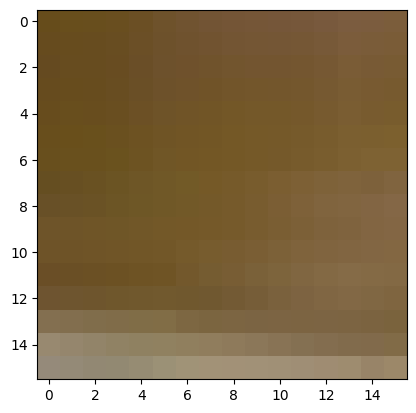

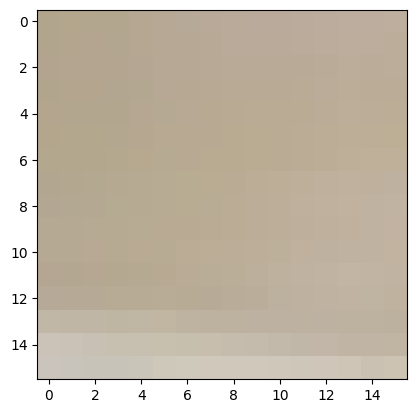

0.5
(60000, 16, 16, 3) (60000, 16, 16, 3) 60000


In [14]:
temp = h5py.File('train_data.hdf5', 'r')
# temp = model.load_weights('tra')
print(temp.keys())
plt.imshow(temp['clear_image'][1000])
plt.show()
plt.imshow(temp['haze_image'][1000])
plt.show()
print(temp['transmission_value'][1000])
print(temp['clear_image'].shape,temp['haze_image'].shape,len(temp['transmission_value']))
temp.close()

In [15]:
!cp './train_data.hdf5' './train_data_patch_16x16.hdf5'

### Residual Data


In [16]:
def TransmissionModel(input_shape):
    """
    Implementation of the Model.
    
    Arguments:
    input_shape -- shape of the images of the dataset
        (height, width, channels) as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]

    Returns:
    model -- a Model() instance in Keras
    """
    
    X_input = Input(input_shape, name = 'input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides = (1, 1), name = 'conv1')(X_input)
    X = Activation('relu', name = 'activation1')(X)

    # SLICE Block applied to X
    X1 = Lambda(lambda X: X[:,:,:,:4], name = 'slice1')(X)
    X2 = Lambda(lambda X: X[:,:,:,4:8], name = 'slice2')(X)
    X3 = Lambda(lambda X: X[:,:,:,8:12], name = 'slice3')(X)
    X4 = Lambda(lambda X: X[:,:,:,12:], name = 'slice4')(X)

    # MAXIMUM Block applied to 4 slices
    X = Maximum(name = 'merge1_maximum')([X1,X2,X3,X4])

    # CONV BLock for multi-scale mapping with filters of size 3x3, 5x5, 7x7
    X_3x3 = Conv2D(16, (3, 3), strides = (1, 1), padding = 'same', name = 'conv2_3x3')(X)
    X_5x5 = Conv2D(16, (5, 5), strides = (1, 1), padding = 'same', name = 'conv2_5x5')(X)
    X_7x7 = Conv2D(16, (7, 7), strides = (1, 1), padding = 'same', name = 'conv2_7x7')(X)

    # CONCATENATE Block to join 3 multi-scale layers
    X = Concatenate(name = 'merge2_concatenate')([X_3x3,X_5x5,X_7x7])

    # MAXPOOL layer of filter size 7x7
    X = MaxPooling2D((7, 7), strides = (1, 1), name = 'maxpool1')(X)
    
    # CONV -> RELU BLock
    X = Conv2D(1, (8, 8), strides = (1, 1), name = 'conv3')(X)
    X = Activation('relu', name = 'activation2')(X)

    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name='TransmissionModel')

    return model

def Guidedfilter(im,p,r,eps):
	mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r))
	mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r))
	mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r))
	cov_Ip = mean_Ip - mean_I*mean_p
	mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r))
	var_I   = mean_II - mean_I*mean_I
	a = cov_Ip/(var_I + eps)
	b = mean_p - a*mean_I
	mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r))
	mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r))
	q = mean_a*im + mean_b
	return q

def TransmissionRefine(im,et):
	gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
	gray = np.float64(gray)/255
	r = 60
	eps = 0.0001
	t = Guidedfilter(gray,et,r,eps)
	return t

In [17]:
file = './train_data.hdf5'
train_dataset = h5py.File(file, 'r')
clean_image = np.array(train_dataset['clear_image'][:])
haze_image = np.array(train_dataset['haze_image'][:])
transmission_value = np.array(train_dataset['transmission_value'])

print ("number of training examples:", clean_image.shape[0])
print ("Clean Image Patch shape:", clean_image.shape)
print ("Haze Image Patch shape:", haze_image.shape)

number of training examples: 60000
Clean Image Patch shape: (60000, 16, 16, 3)
Haze Image Patch shape: (60000, 16, 16, 3)


In [18]:
tm_model = TransmissionModel((31,31,3))
tm_model.load_weights("C:/Users/adity/OneDrive/Desktop/211172/Major Project/Aditya/Jupyter Notebooks-20241129T163236Z-001/Jupyter Notebooks/Model and Weights/Weights/transmodel_weights.h5")
c = np.pad(haze_image,((0,0), (7,8), (7,8), (0,0)), 'symmetric')
nyu_transmission_map = tm_model.predict(c)
b = nyu_transmission_map.reshape(60000,16,16)
d = (haze_image*255.0).astype('uint8')
for i,val in enumerate(b):
    b[i] = TransmissionRefine(d[i],val)
m = nyu_transmission_map.reshape(60000,16,16)



1875/1875 [==============================] - 13s 7ms/step


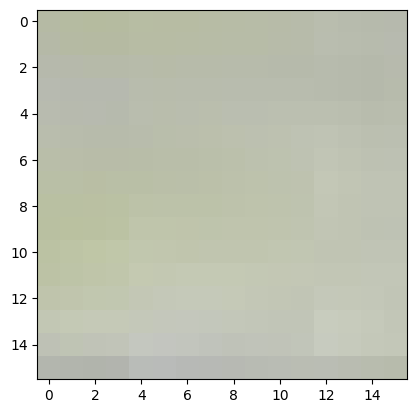

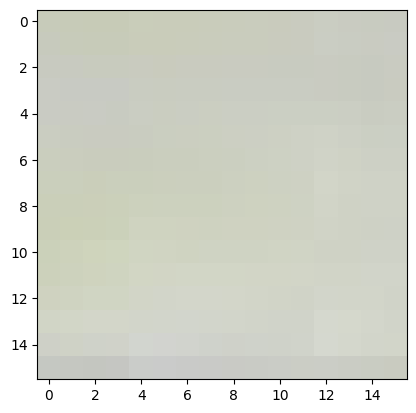

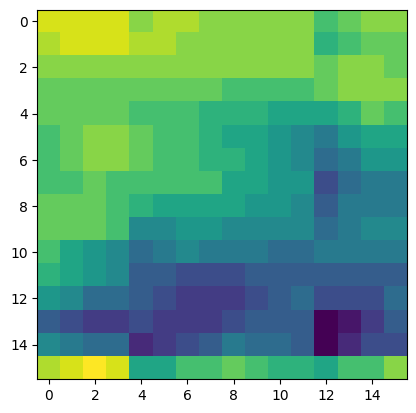

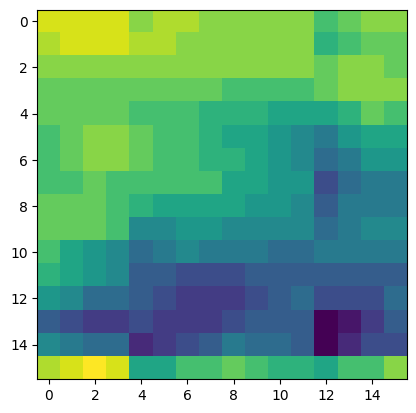

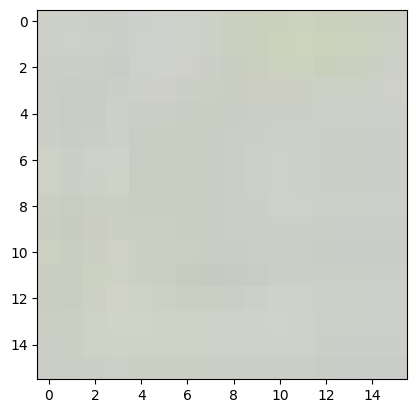

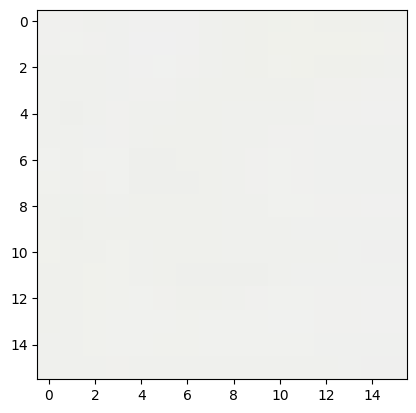

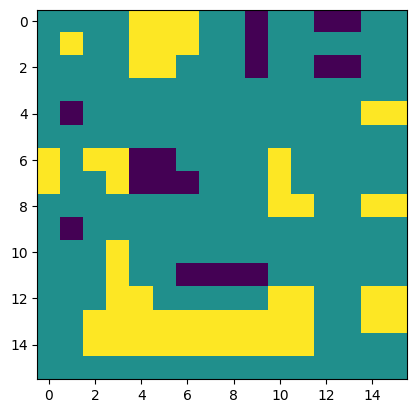

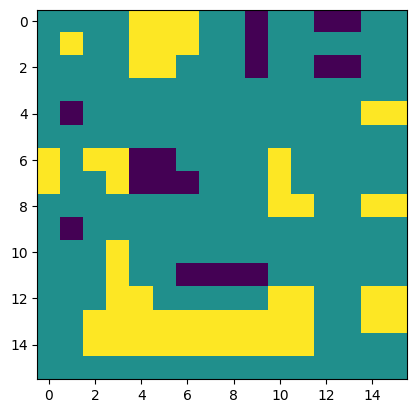

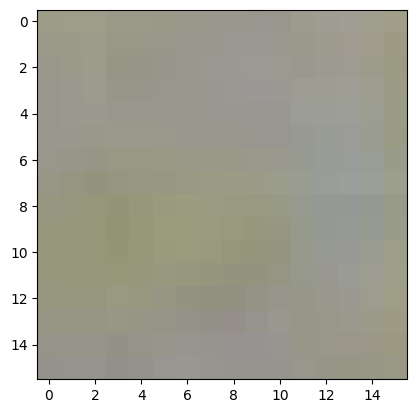

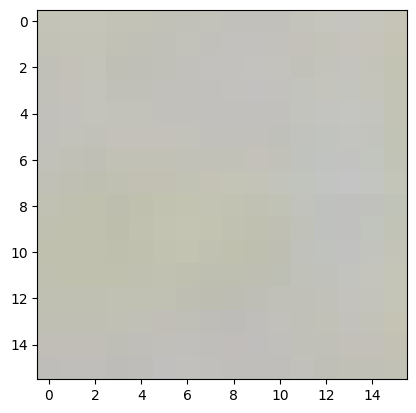

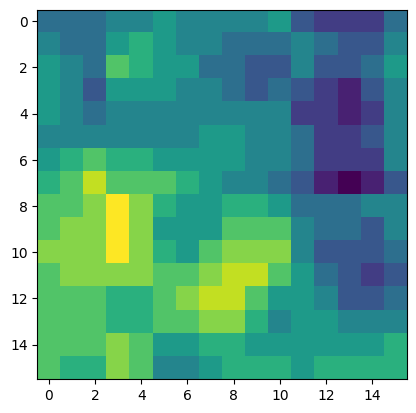

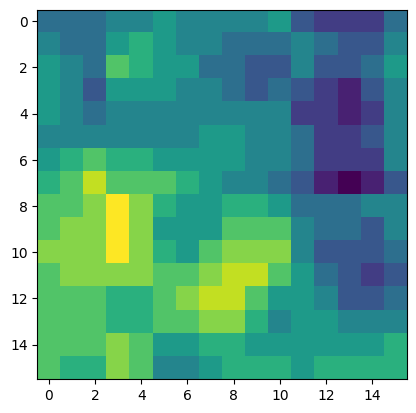

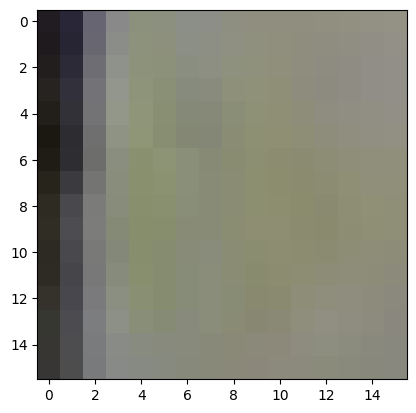

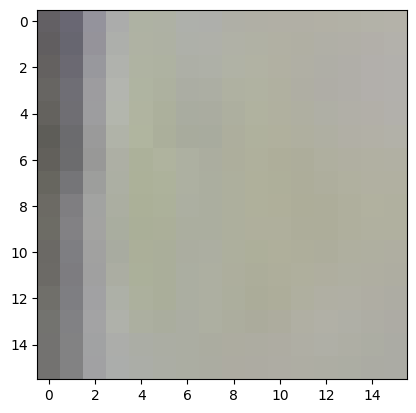

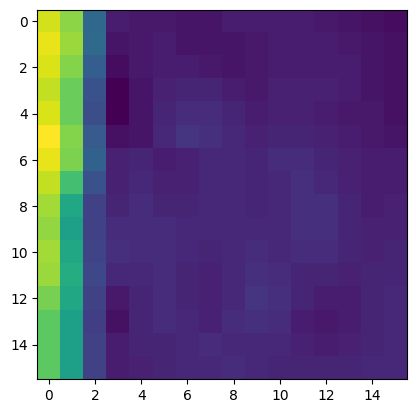

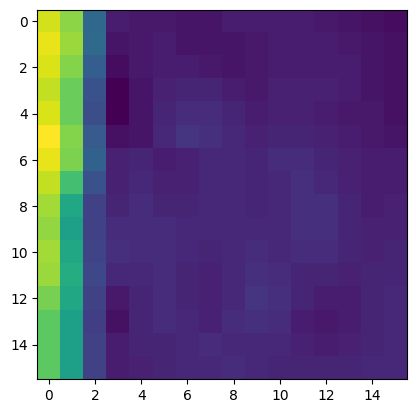

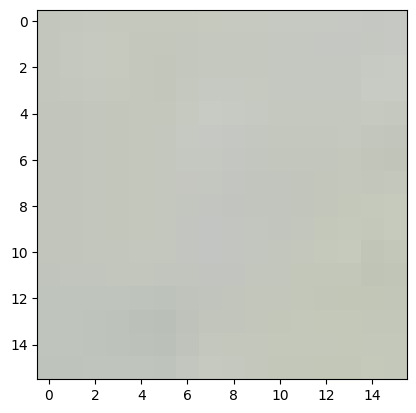

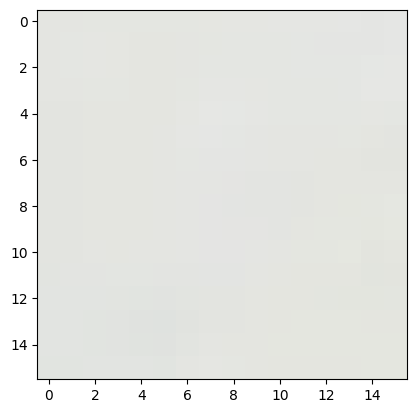

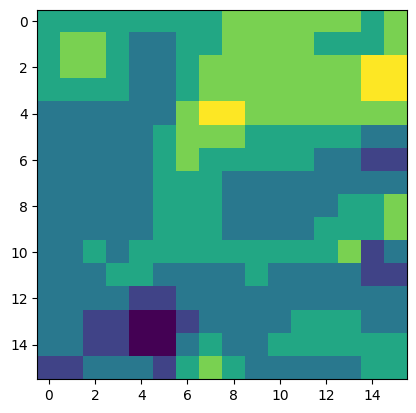

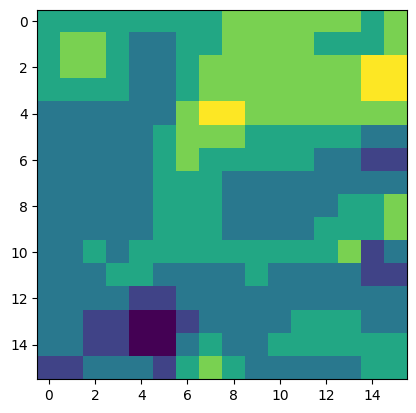

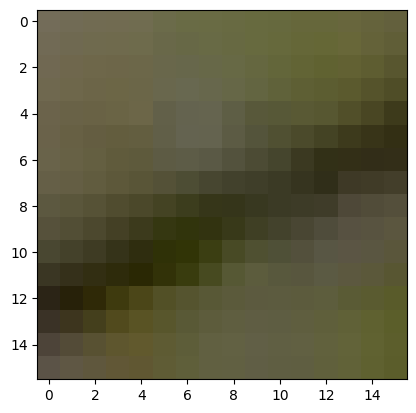

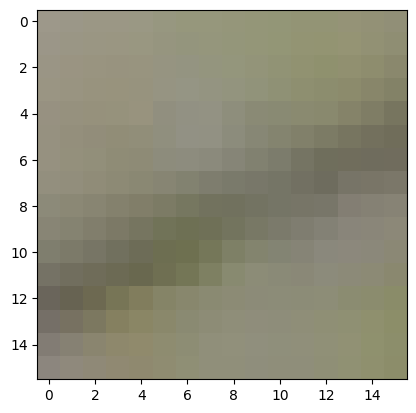

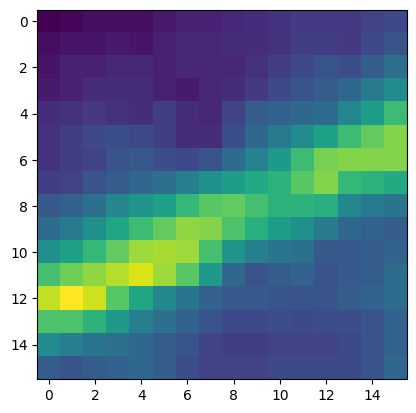

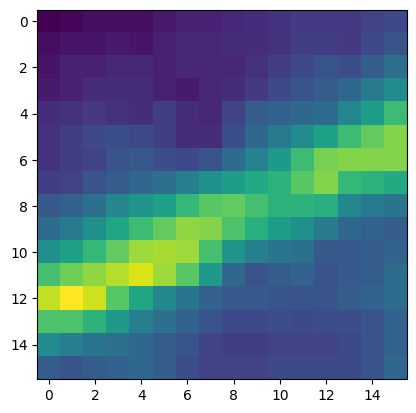

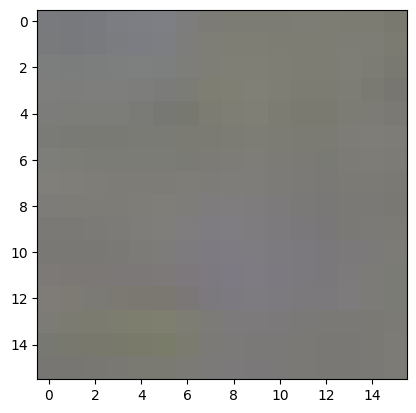

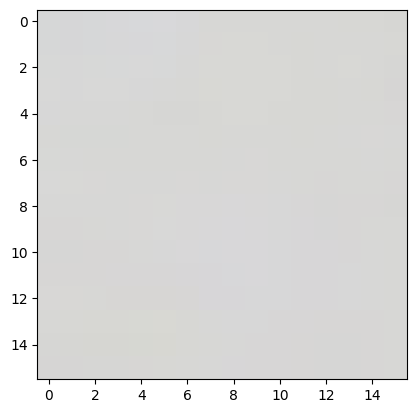

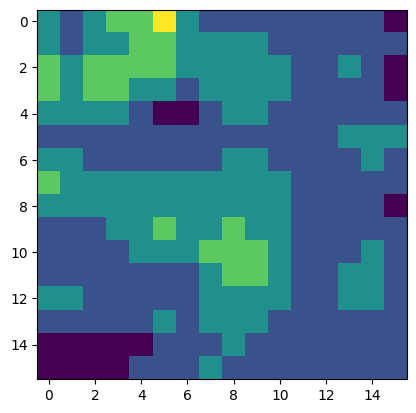

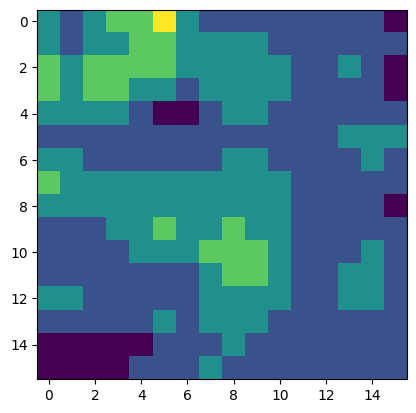

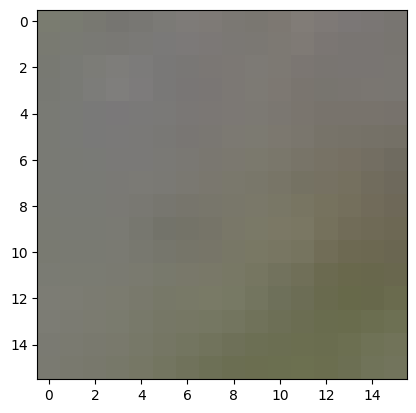

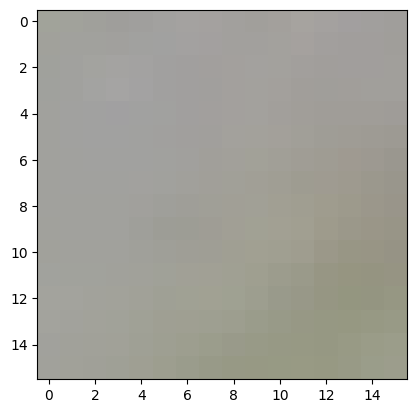

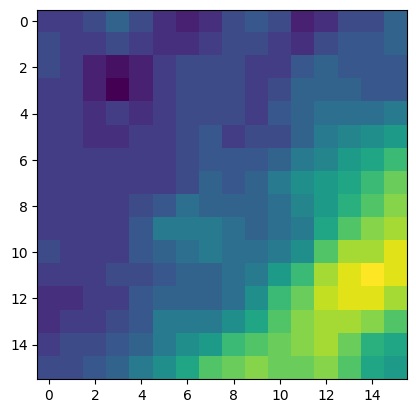

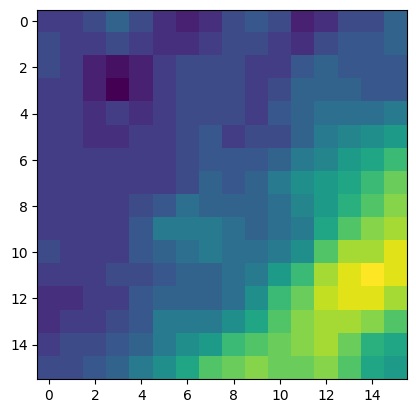

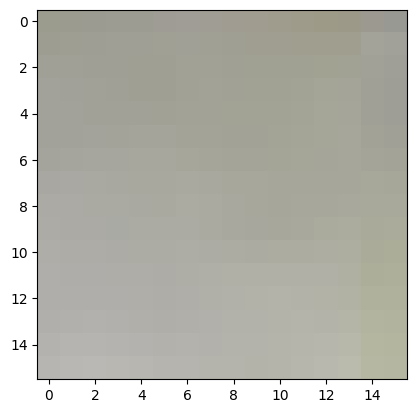

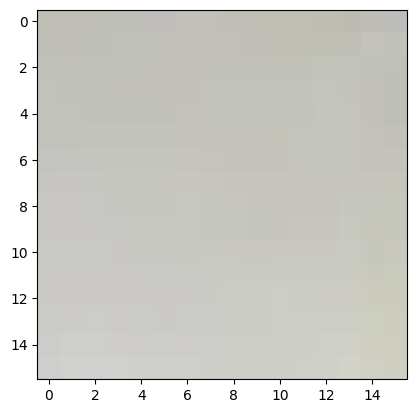

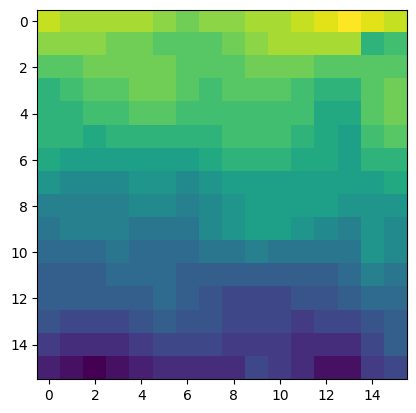

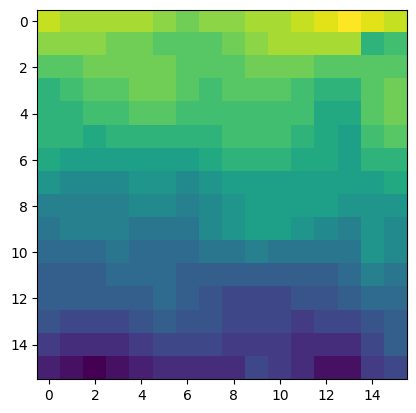

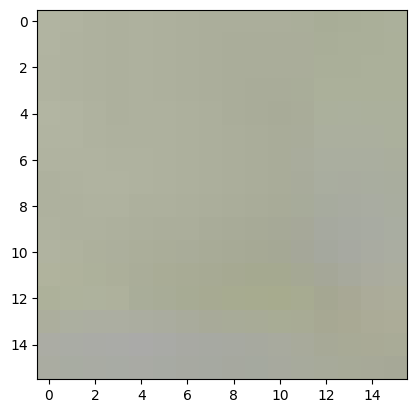

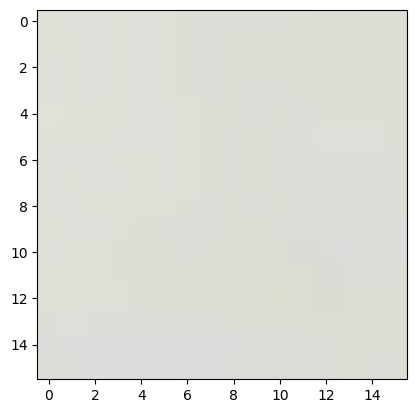

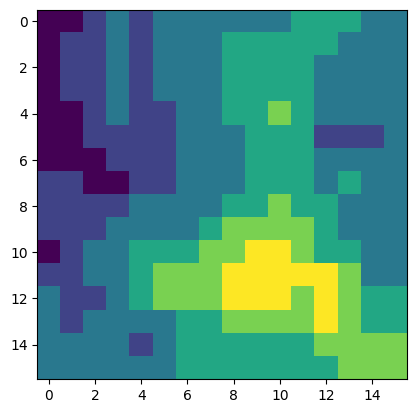

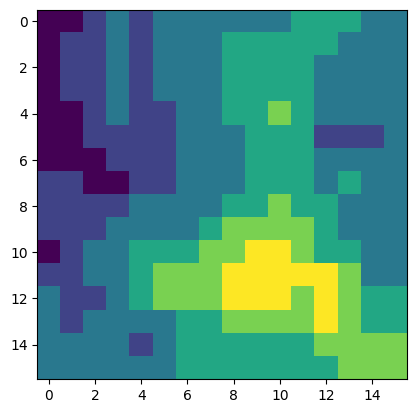

In [19]:
for i in range(10):
    plt.imshow(clean_image[i])
    plt.show()
    plt.imshow(haze_image[i])
    plt.show()
    plt.imshow(m[i])
    plt.show()
    plt.imshow(b[i])
    plt.show()

In [20]:
train_dataset = h5py.File("mj.hdf5", "w")
train_dataset.create_dataset("clear_image",data = clean_image,compression=9,shuffle=True)
train_dataset.create_dataset("transmission_map",data = m,compression=9,shuffle=True)
train_dataset.create_dataset("transmission_map_refine",data = b,compression=9,shuffle=True)
train_dataset.create_dataset("haze_image",data = haze_image,compression=9,shuffle=True)
train_dataset.close()